# MNIST DCGAN

Import libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

import IPython
from IPython import display

Ensure we use TensorFlow 2.0 Alpha

In [2]:
tf.__version__

'2.0.0-alpha0'

Prepare dataset

In [4]:
# load dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# reshape the images to have three dimensions
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

See how many training images there are

In [5]:
print(train_images.shape)

(60000, 28, 28, 1)


Define constants

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# shuffle and batch the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Define the generator model

In [13]:
def create_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

Test if the generator works

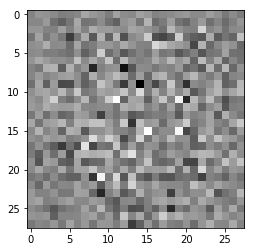

In [14]:
generator = create_generator_model()

# input to the generator 
noise = tf.random.normal([1, 100])

# generate image from noise
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Define the discriminator model

In [15]:
def create_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    assert model.output_shape == (None, 7*7*128)
    
    model.add(layers.Dense(1))
    assert model.output_shape == (None, 1)
    
    return model

Test if the discriminator works

In [16]:
discriminator = create_discriminator_model()

# pass the generated image from the generator above
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00225872]], shape=(1, 1), dtype=float32)


Define the loss functions

In [17]:
# helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

The discriminator loss reflects the discriminator's goal to classify the training image as 1 and the generated image as 0

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

The generator loss reflects the generator's goal to fool the discriminator into classifying the generated image as 1

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Initialize both models' optimizers

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Initialize directories for images and checkpoints

In [22]:
images_dir = 'images'
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Initialize test input to the generator

In [23]:
noise_dim = 100
num_examples_to_generate = 16

# we will reuse this seed overtime (so it's eaier)
# to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Define a helper function to compute gradients and update parameters

In [24]:
# this annotation caues the function to be "compiled"
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # compute the gradient of the generator loss with respect to its parameters
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # compute the gradient of the discriminator loss with respect to its parameters
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # pass a list of tuples of gradient and its associated parameter
    # to update the gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

Define the training function

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # produce images for GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        end_time = time.time() - start_time
        print('Time for epoch {} is {} sec'.format(epoch + 1, end_time))

Define a helper function to generate and save images

In [26]:
def generate_and_save_images(model, epoch, test_input):
    # set `training` to false
    # all layers run in inference mode (batchnorm)
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig(images_dir + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Train models

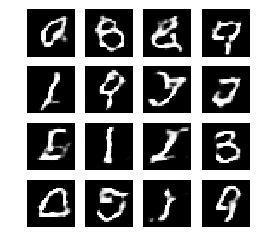

Time for epoch 50 is 13.880139112472534 sec
CPU times: user 3min 4s, sys: 49.3 s, total: 3min 53s
Wall time: 11min 34s


In [27]:
%%time
EPOCHS = 50
train(train_dataset, EPOCHS)

Restore the latest checkpoint

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

See the image generated at the last epoch

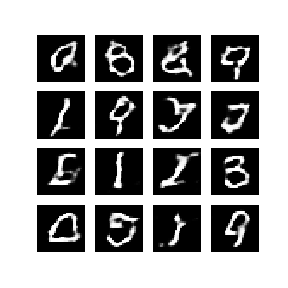

In [31]:
# display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open(images_dir + '/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

Define a function to create a gif consisting of images from all epochs

In [32]:
def create_gif(gif_file_path, skip_frames=False):
    with imageio.get_writer(gif_file_path, mode='I') as writer:
        # find filenames of all images in the current directory with the specified pattern
        filenames = glob.glob(images_dir + '/image*.png')

        # sort the filenames
        filenames = sorted(filenames)

        last = -1
        for i, filename in enumerate(filenames):
            if skip_frames:
                frame = 2*(i**0.5)
                if round(frame) > round(last):
                    last = frame
                else:
                    continue
                    
            # read the image from the specified uri
            image = imageio.imread(filename)

            # append an image and meta data to the file
            writer.append_data(image)

Create the gif

In [33]:
gif_file_path = images_dir + '/mnist-dcgan.gif'
create_gif(gif_file_path, skip_frames=False)

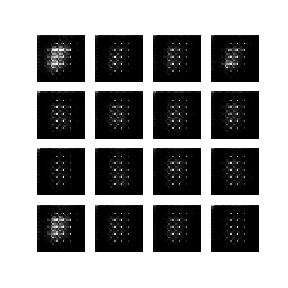

In [34]:
if IPython.version_info > (6, 2, 0, ''):
    # get image object
    image = display.Image(filename=gif_file_path)
    
    # display image
    display.display(image)